## Cell 1: Setup and Installations

In [7]:
# Install necessary libraries
!pip install torch torchvision pandas scikit-learn datasets huggingface_hub torchmetrics tqdm kagglehub -q

# --- Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm.notebook import tqdm
from torchvision import transforms, models
import matplotlib.pyplot as plt
import kagglehub
import os

# Import the correct metrics for BINARY classification
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

## Cell 2: Load and Explore the CIFAKE Dataset

In [8]:
# --- 1. Download the dataset using KaggleHub ---
print("Downloading dataset from Kaggle...")
dataset_path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print(f"Dataset downloaded to: {dataset_path}")

# --- 2. Load the data from the local folder ---
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

print(f"\nLoading images from local directories...")
dataset = load_dataset(
    'imagefolder',
    data_files={
        'train': f"{train_dir}/**",
        'test': f"{test_dir}/**"
    }
)

# --- 3. Verify the loaded dataset ---
print("\nDataset loaded successfully!")
print(dataset)

Using Colab cache for faster access to the 'cifake-real-and-ai-generated-synthetic-images' dataset.
Dataset downloaded to: /kaggle/input/cifake-real-and-ai-generated-synthetic-images

Loading images from local directories...


Resolving data files:   0%|          | 0/100000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20000 [00:00<?, ?it/s]


Dataset loaded successfully!
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 20000
    })
})


## Cell 3 : Update Image Size in Preprocessing (Cell 3)

In [9]:
# --- 3.1 Define Image Transformations ---
def get_transforms(image_size=380): # Optimal size for EfficientNet-B4
    """Returns a dictionary of data transforms."""
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(image_size + 20),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])
    return {'train': train_transforms, 'val': val_transforms}

# --- 3.2 Apply Transforms and Create DataLoaders ---
image_transforms = get_transforms()

def apply_train_transforms(batch):
    batch['pixel_values'] = [image_transforms['train'](img.convert("RGB")) for img in batch['image']]
    return batch

def apply_val_transforms(batch):
    batch['pixel_values'] = [image_transforms['val'](img.convert("RGB")) for img in batch['image']]
    return batch

dataset['train'].set_transform(apply_train_transforms)
dataset['test'].set_transform(apply_val_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['label'] for example in examples], dtype=torch.float32).unsqueeze(1)
    return {'pixel_values': pixel_values, 'labels': labels}

batch_size = 32 # A smaller batch size is better for large images (380x380)
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"Data preprocessing complete.")
print(f"Created Train DataLoader with {len(train_loader)} batches of size {batch_size}")
print(f"Created Test DataLoader with {len(test_loader)} batches of size {batch_size}")

Data preprocessing complete.
Created Train DataLoader with 3125 batches of size 32
Created Test DataLoader with 625 batches of size 32


## Cell 4: Define the New EfficientNet-B4 Model

In [10]:
# --- 4. Define the New EfficientNet-B4 Model ---
def build_model(pretrained=True):
    """Builds a pre-trained EfficientNet-B4 model for transfer learning."""
    weights = models.EfficientNet_B4_Weights.DEFAULT if pretrained else None
    model = models.efficientnet_b4(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1)

    return model

# --- Instantiate the model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

print("Model architecture defined using EfficientNet-B4:")
print(f"Model moved to device: {device}")

Model architecture defined using EfficientNet-B4:
Model moved to device: cuda


## Cell 5: Training and Validation Engine

In [11]:
# --- 5. Setup for Training ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

accuracy = BinaryAccuracy().to(device)
precision_metric = BinaryPrecision().to(device)
recall = BinaryRecall().to(device)
f1_score = BinaryF1Score().to(device)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(loader, desc="Training")

    for batch in progress_bar:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    accuracy.reset(); precision_metric.reset(); recall.reset(); f1_score.reset()

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating"):
            inputs = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs)
            accuracy.update(preds, labels.int())
            precision_metric.update(preds, labels.int())
            recall.update(preds, labels.int())
            f1_score.update(preds, labels.int())

    avg_loss = running_loss / len(loader)
    acc = accuracy.compute()
    prec = precision_metric.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    return avg_loss, acc, prec, rec, f1


## Cell 6: Training Execution

In [13]:
# --- 6. Main Training Loop ---
num_epochs = 15
best_val_f1 = 0.0

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")

    val_loss, val_acc, val_prec, val_rec, val_f1 = validate(model, test_loader, criterion)
    print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")
    print(f"Validation -> Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1-Score: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_cifake_model.pth")
        print(f"New best model saved with F1-Score: {best_val_f1:.4f}")

print("\n--- Training Finished ---")


--- Epoch 1/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 Training Loss: 0.4973


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 0.3969
Validation -> Accuracy: 0.8287, Precision: 0.8731, Recall: 0.7692, F1-Score: 0.8179
New best model saved with F1-Score: 0.8179

--- Epoch 2/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 Training Loss: 0.4655


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 0.3722
Validation -> Accuracy: 0.8418, Precision: 0.8648, Recall: 0.8103, F1-Score: 0.8367
New best model saved with F1-Score: 0.8367

--- Epoch 3/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 Training Loss: 0.4576


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 0.3678
Validation -> Accuracy: 0.8438, Precision: 0.8837, Recall: 0.7918, F1-Score: 0.8352

--- Epoch 4/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4 Training Loss: 0.4599


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 0.3619
Validation -> Accuracy: 0.8446, Precision: 0.8824, Recall: 0.7953, F1-Score: 0.8366

--- Epoch 5/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5 Training Loss: 0.4573


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 0.3607
Validation -> Accuracy: 0.8454, Precision: 0.8700, Recall: 0.8123, F1-Score: 0.8402
New best model saved with F1-Score: 0.8402

--- Epoch 6/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6 Training Loss: 0.4589


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 0.3611
Validation -> Accuracy: 0.8475, Precision: 0.8952, Recall: 0.7871, F1-Score: 0.8377

--- Epoch 7/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7 Training Loss: 0.4552


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 0.3599
Validation -> Accuracy: 0.8464, Precision: 0.8860, Recall: 0.7951, F1-Score: 0.8381

--- Epoch 8/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8 Training Loss: 0.4558


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 0.3580
Validation -> Accuracy: 0.8460, Precision: 0.8837, Recall: 0.7969, F1-Score: 0.8380

--- Epoch 9/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9 Training Loss: 0.4564


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 0.3596
Validation -> Accuracy: 0.8467, Precision: 0.8936, Recall: 0.7871, F1-Score: 0.8370

--- Epoch 10/15 ---


Training:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10 Training Loss: 0.4583


Validating:   0%|          | 0/625 [00:00<?, ?it/s]

KeyboardInterrupt: 

##Cell 7: Visualize Predictions on Random Images

Successfully loaded 'best_cifake_model.pth'
Fetching a random batch of data from the test set...
Predictions generated.
Displaying results... (Correct predictions in green, incorrect in red)


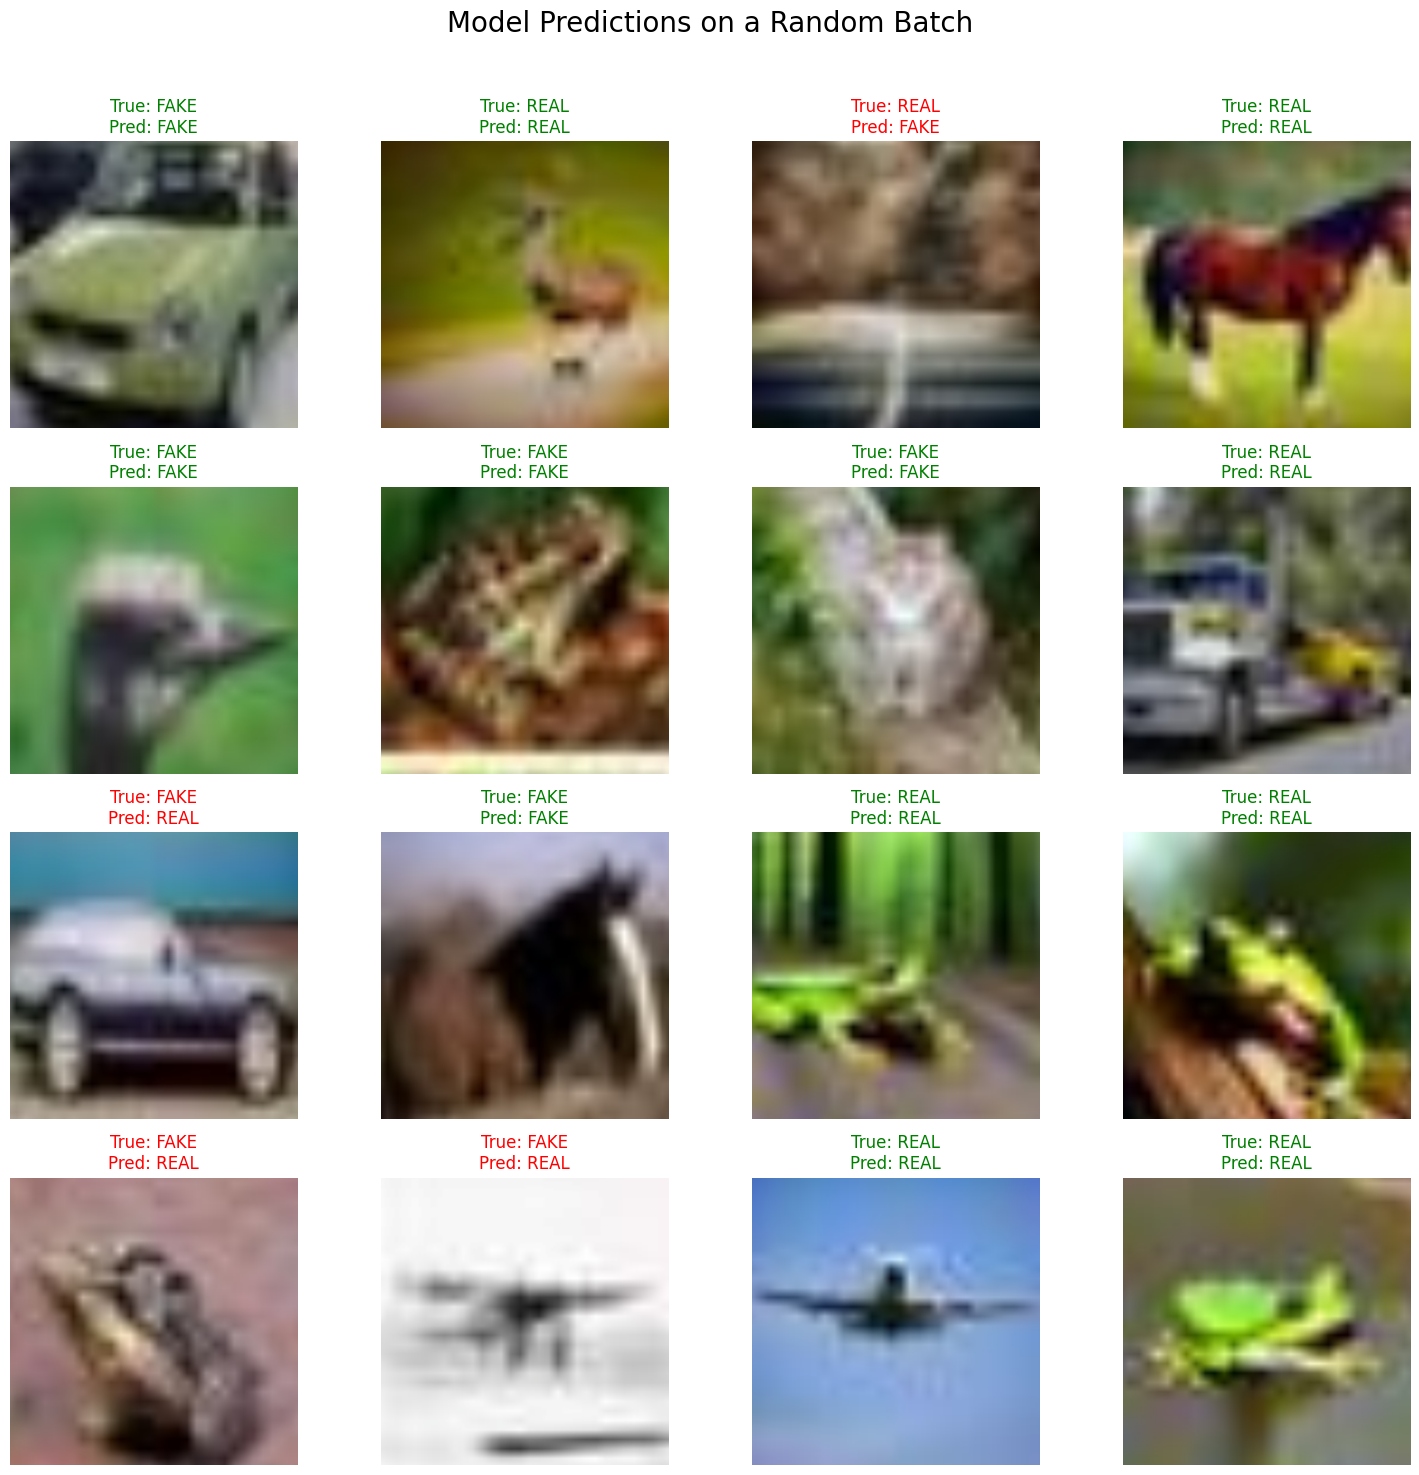

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- 1. Load the Best Model ---
# Ensure the model architecture is defined and on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

# Load the saved weights from the best epoch
try:
    model.load_state_dict(torch.load("best_cifake_model.pth"))
    print("Successfully loaded 'best_cifake_model.pth'")
except FileNotFoundError:
    print("Error: 'best_cifake_model.pth' not found. Please ensure the model was trained and saved.")

model.eval() # Set the model to evaluation mode

# --- 2. Get a Randomly Shuffled Batch of Data ---
# We create a new, shuffled loader just for visualization.
# batch_size=16 is good for a 4x4 grid.
shuffled_loader = DataLoader(dataset['test'], batch_size=16, shuffle=True, collate_fn=collate_fn)

print("Fetching a random batch of data from the test set...")
batch = next(iter(shuffled_loader))

inputs = batch['pixel_values'].to(device)
labels = batch['labels'] # Keep labels on CPU for plotting

# --- 3. Make Predictions ---
with torch.no_grad():
    outputs = model(inputs)
    # Convert logits to probabilities and then to predicted classes (0 or 1)
    preds = torch.sigmoid(outputs) > 0.5

# Move data to CPU for visualization with numpy/matplotlib
inputs_cpu = inputs.cpu()
preds_cpu = preds.cpu()
print("Predictions generated.")

# --- 4. Visualize the Results ---
label_names = {0: 'REAL', 1: 'FAKE'}

# Function to denormalize images for proper viewing
def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    denormalized_tensor = tensor.clone()
    for t, m, s in zip(denormalized_tensor, mean, std):
        t.mul_(s).add_(m)
    return denormalized_tensor

print("Displaying results... (Correct predictions in green, incorrect in red)")
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Model Predictions on a Random Batch', fontsize=20)

for i, ax in enumerate(axes.flatten()):
    img = denormalize(inputs_cpu[i])

    # Get true and predicted label names
    true_label = label_names[int(labels[i].item())]
    pred_label = label_names[int(preds_cpu[i].item())]

    # Set title color based on correctness
    title_color = "green" if true_label == pred_label else "red"

    # PyTorch tensors are (C, H, W), Matplotlib expects (H, W, C)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##Cell 8: Comprehensive Model Evaluation

Successfully loaded 'best_cifake_model.pth'
Running evaluation on the entire test set...


Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]


CLASSIFICATION REPORT
                precision    recall  f1-score   support

REAL (Class 0)       0.82      0.88      0.85     10000
FAKE (Class 1)       0.87      0.81      0.84     10000

      accuracy                           0.85     20000
     macro avg       0.85      0.85      0.85     20000
  weighted avg       0.85      0.85      0.85     20000


CONFUSION MATRIX


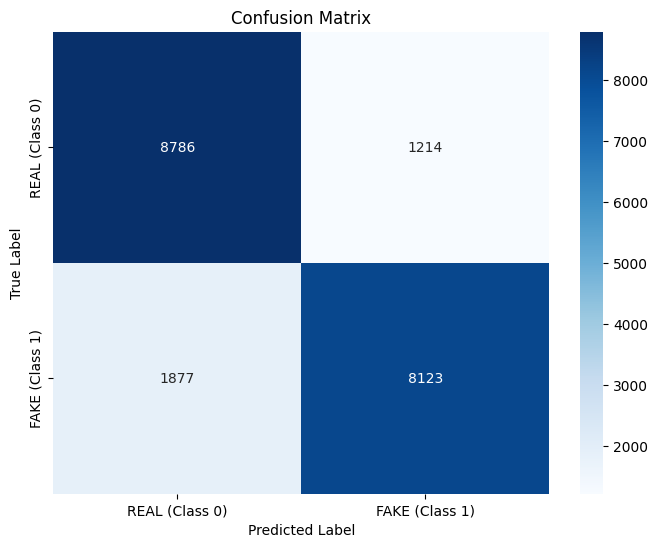


ROC CURVE & AUC SCORE


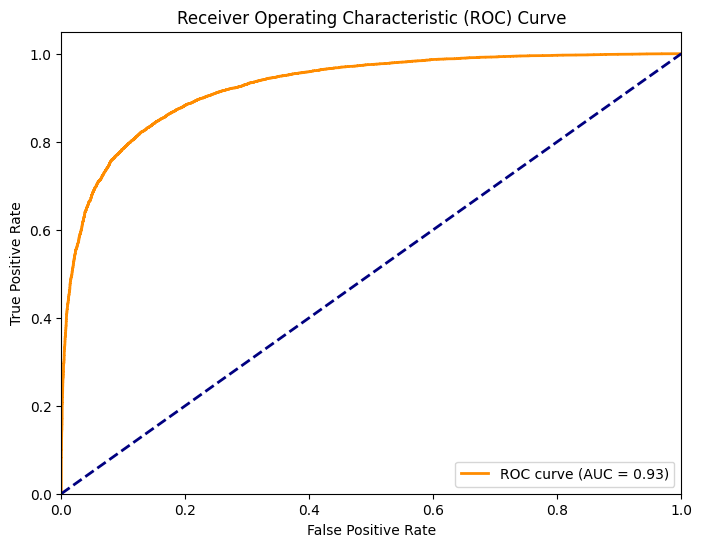


Area Under Curve (AUC): 0.9259


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from tqdm.notebook import tqdm

# --- 1. Load the Best Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model().to(device)

try:
    model.load_state_dict(torch.load("best_cifake_model.pth"))
    print("Successfully loaded 'best_cifake_model.pth'")
except FileNotFoundError:
    print("Error: 'best_cifake_model.pth' not found. Please ensure the model was trained and saved.")

model.eval() # Set the model to evaluation mode

# --- 2. Get All Predictions from the Test Set ---
all_labels = []
all_preds = []
all_probs = []

print("Running evaluation on the entire test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels']

        outputs = model(inputs)

        # Get probabilities for ROC curve
        probs = torch.sigmoid(outputs).cpu()
        # Get final predictions (0 or 1)
        preds = (probs > 0.5).int()

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.numpy())

# Convert lists to numpy arrays for scikit-learn
all_labels = np.array(all_labels).flatten()
all_preds = np.array(all_preds).flatten()
all_probs = np.array(all_probs).flatten()

# --- 3. Display Classification Report ---
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
# Define target names for the report
target_names = ['REAL (Class 0)', 'FAKE (Class 1)']
print(classification_report(all_labels, all_preds, target_names=target_names))

# --- 4. Display Confusion Matrix ---
print("\n" + "="*50)
print("CONFUSION MATRIX")
print("="*50)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 5. Display ROC Curve and AUC Score ---
print("\n" + "="*50)
print("ROC CURVE & AUC SCORE")
print("="*50)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"\nArea Under Curve (AUC): {auc_score:.4f}")

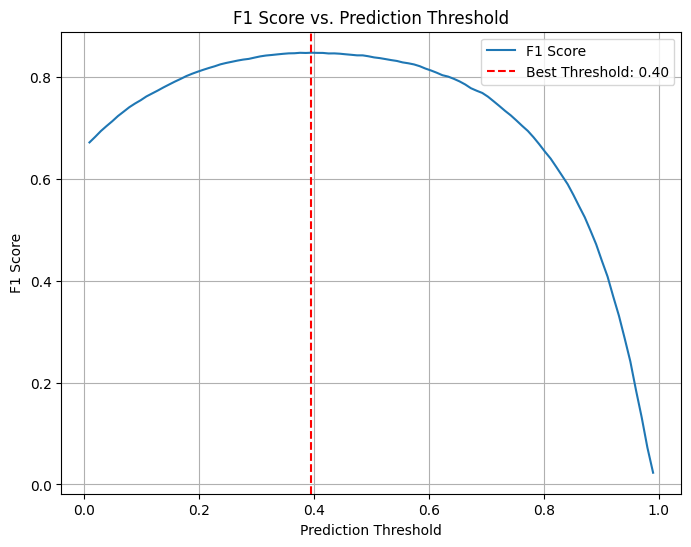

Optimal threshold to maximize F1-score is: 0.3961
Best F1-score at this threshold: 0.8479


In [16]:
from sklearn.metrics import f1_score as sk_f1_score

# Test thresholds from 0.01 to 0.99
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = [sk_f1_score(all_labels, all_probs > t) for t in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Plot the F1 score vs. Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Prediction Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Prediction Threshold')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal threshold to maximize F1-score is: {best_threshold:.4f}")
print(f"Best F1-score at this threshold: {best_f1:.4f}")

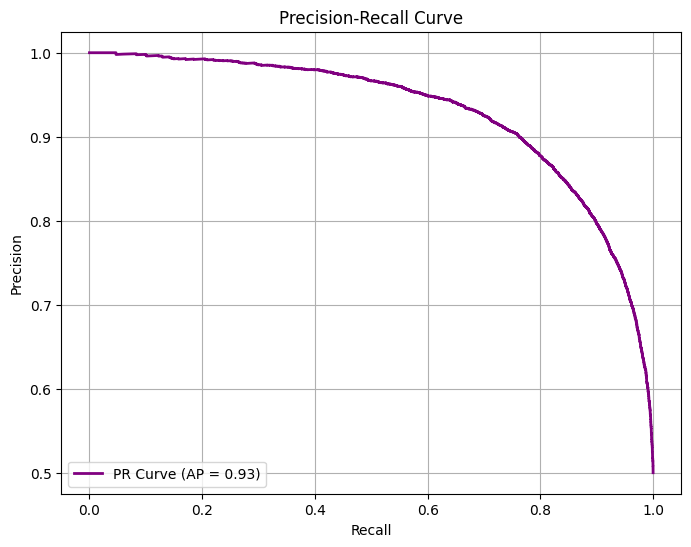


Average Precision (AP) Score: 0.9290


In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {ap_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"\nAverage Precision (AP) Score: {ap_score:.4f}")